In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np

import os
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/train.csv')

In [ ]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns),
    ]
)

In [ ]:
X = preprocessor.fit_transform(df)

In [ ]:
metadata = []
for col in categorical_columns:
  data = df[[col]].values
  ohe = OneHotEncoder(sparse_output=False)
  ohe.fit(data)
  categories = len(ohe.categories_[0])
  metadata.append(categories)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
noise_dim = 128
generator = Generator(input_dim=noise_dim, output_dim=X.shape[1]).to(device)
discriminator = Discriminator(input_dim=X.shape[1]).to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-4)

In [ ]:
def apply_activate(data):
  data_t = []
  start_ind = 0
  for ind in metadata:
    data_t.append(F.softmax(data[:,start_ind:start_ind+ind],dim=1))
    start_ind += ind
  return torch.cat(data_t, dim=1)

In [ ]:
epochs = 500

In [ ]:
train_dataloader = DataLoader(torch.tensor(X, dtype=torch.float32), batch_size=32, shuffle=True)

In [ ]:
G_losses = []
D_losses = []

for epoch in range(epochs):
  for i,real_data in enumerate(train_dataloader):
      noise = torch.randn(real_data.size(0), noise_dim,dtype=torch.float32).to(device)
      optimizer_discriminator.zero_grad()
      real_labels = torch.ones(real_data.size(0), 1).to(device)
      output_real = discriminator(real_data.to(device))
      loss_real = criterion(output_real, real_labels)

      fake = generator(noise)
      fakeact = apply_activate(fake)

      output_fake = discriminator(fakeact)
      fake_labels = torch.zeros(real_data.size(0), 1).to(device)
      loss_fake = criterion(output_fake, fake_labels)

      # Combine Losses for discriminator and Update
      loss_disc = loss_real + loss_fake
      loss_disc.backward(retain_graph=True)
      optimizer_discriminator.step()

      optimizer_generator.zero_grad()
      output = discriminator(fakeact)
      loss_gen = criterion(output, real_labels)
      loss_gen.backward()
      optimizer_generator.step()

      G_losses.append(loss_gen.item())
      D_losses.append(loss_disc.item())

      if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, epochs, i, len(train_dataloader), loss_disc.item(), loss_gen.item(), output_real.mean().item(), output_fake.mean().item(), output.mean().item()))


Streaming output truncated to the last 5000 lines.
[321/500][600/1374]	Loss_D: 0.6314	Loss_G: 1.7291	D(x): 0.7744	D(G(z)): 0.1895 / 0.1855
[321/500][650/1374]	Loss_D: 0.6030	Loss_G: 1.7356	D(x): 0.8001	D(G(z)): 0.1917 / 0.1939
[321/500][700/1374]	Loss_D: 0.6864	Loss_G: 1.7119	D(x): 0.7595	D(G(z)): 0.2102 / 0.2050
[321/500][750/1374]	Loss_D: 0.5990	Loss_G: 1.4402	D(x): 0.8333	D(G(z)): 0.2529 / 0.2529
[321/500][800/1374]	Loss_D: 0.8375	Loss_G: 1.7289	D(x): 0.7107	D(G(z)): 0.2293 / 0.2259
[321/500][850/1374]	Loss_D: 0.9095	Loss_G: 1.3452	D(x): 0.7136	D(G(z)): 0.3008 / 0.2928
[321/500][900/1374]	Loss_D: 0.7427	Loss_G: 1.4521	D(x): 0.7615	D(G(z)): 0.2492 / 0.2516
[321/500][950/1374]	Loss_D: 0.6901	Loss_G: 1.7367	D(x): 0.7566	D(G(z)): 0.1954 / 0.1959
[321/500][1000/1374]	Loss_D: 0.5156	Loss_G: 1.5572	D(x): 0.8720	D(G(z)): 0.2406 / 0.2312
[321/500][1050/1374]	Loss_D: 0.7467	Loss_G: 1.5674	D(x): 0.7334	D(G(z)): 0.2276 / 0.2271
[321/500][1100/1374]	Loss_D: 0.8566	Loss_G: 1.6375	D(x): 0.7002	D(G

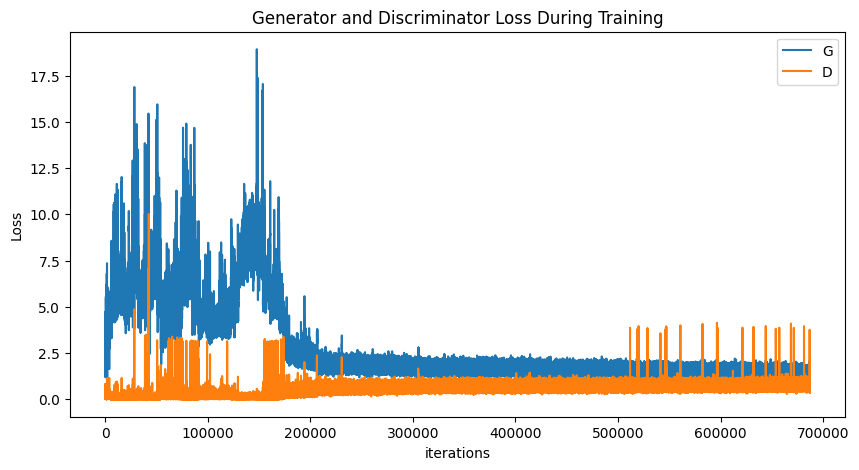

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
